In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
sbn.set_style("white") # get rid of seaborn grid lines

In [2]:
%matplotlib inline
np.random.seed(20160410)

# Sampling Distribution of Pearson Correlation

As with all the other statistics we've looked at over the course of the semester, the sample correlation coefficient may differ substantially from the underly population correlation coefficient, depending on the vagaries of sampling. 

First we'll generate a single sample, drawn from an underlying bivariate normal distribution with uncorrelated variables.

In [3]:
# generate bivariate normal data for uncorrelated variables
# See the docs on scipy.stats.multivariate_normal

# bivariate mean
mean = [0,0]  

# covariance matrix
cov = np.array([[1,0],
                [0,1]])

sample = stats.multivariate_normal.rvs(mean=mean, cov=cov, size=30) 


Correlation matrix:
 [[ 1.         -0.29396167]
 [-0.29396167  1.        ]]


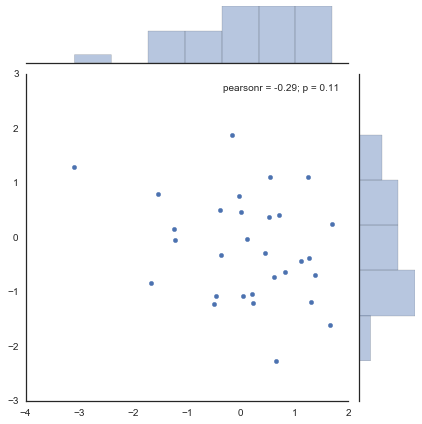

In [4]:
sbn.jointplot(sample[:,0], sample[:,1])
print("Correlation matrix:\n", np.corrcoef(sample, rowvar=False, ddof=1))

### Simulate the sampling distribution of correlation coefficient, uncorrelated variables

First we'll simulate the sampling distribution of $r_{xy}$ when the true population correlation $\rho_{xy} = 0$ and the sample size $n = 30$.

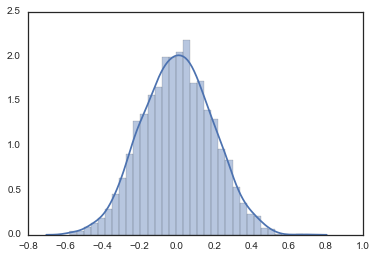

In [5]:
mean = [0,0]
cov = [[1,0],
       [0,1]]
ssize = 30
nsims = 2500

cors = []
for n in range(nsims):
    sample = stats.multivariate_normal.rvs(mean=mean, cov=cov, size=ssize)
    r = np.corrcoef(sample, rowvar=False, ddof=1)[0,1]
    cors.append(r)
sbn.distplot(cors)
pass

The above plot looks fairly symmetrical, and approximately normal.  However, now let's look at the sampling distribution for $\rho_{xy} = 0.9$ and $n=30$.

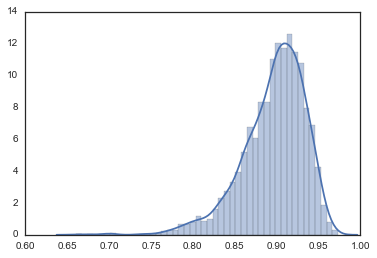

In [6]:
mean = [0,0]
cov = [[1,0.9],
       [0.9,1]]
ssize = 30
nsims = 2500

cors090 = []
for n in range(nsims):
    sample = stats.multivariate_normal.rvs(mean=mean, cov=cov, size=ssize)
    r = np.corrcoef(sample, rowvar=False, ddof=1)[0,1]
    cors090.append(r)
    
sbn.distplot(cors090)
pass

We see that the sampling correlation is strongly skewed for larger values of $\rho_{xy}$

Fisher's transformation normalizes the distribution of the Pearson product-moment correlation, and is usually used to calculate confidence intervals and carry out hypothesis test with correlations.

$$
F(r) = \frac{1}{2}\ln \frac{1+r}{1-r} = \mbox{arctanh}(r)
$$

Where $\mbox{arctanh}(r)$ is the inverse hyperbolic tangent of the correlation coefficient.

If the underlying true correlation is $\rho$, the sampling distribution of $F(\rho)$ is approximately normal:
$$
F(\rho) \sim N(\mu = \mbox{arctanh}(\rho),\ \sigma = \frac{1}{\sqrt{n-3}})
$$


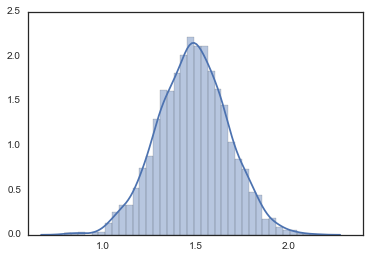

In [7]:
# plot for sampling distribution when pho = 0.9
# using Fisher's transformation
sbn.distplot(np.arctanh(cors090))
print("")
pass

Confidence intervals in the space of the transformed variables are:

$$
100(1 - \alpha)\%\text{CI}: \operatorname{arctanh}(\rho) \in [\operatorname{arctanh}(r) \pm z_{\alpha/2}SE]
$$

To put this back in terms of untransformed correlations:

$$
100(1 - \alpha)\%\text{CI}: \rho \in [\operatorname{tanh}(\operatorname{arctanh}(r) - z_{\alpha/2}SE), \operatorname{tanh}(\operatorname{arctanh}(r) + z_{\alpha/2}SE)]
$$

Let's write a Python function to calculate the confidence intervals for correlations:

In [8]:
def correlationCI(r, n, alpha=0.05):
    mu = np.arctanh(r)
    sigma = 1.0/np.sqrt(n-3)
    z = stats.norm.ppf(alpha/2)
    left = np.tanh(mu) - z*sigma
    right = np.tanh(mu) + z*sigma
    return (left, right)
    

In [9]:
correlationCI(0, 30)

(0.37719524469205734, -0.37719524469205734)

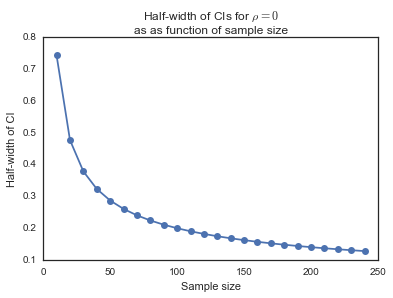

In [10]:
ssizes = np.arange(10,250,step=10)
cis = []
for i in ssizes:
    cis.append(correlationCI(0, i)[0])

plt.plot(ssizes, cis, '-o')
plt.xlabel("Sample size")
plt.ylabel("Half-width of CI")
plt.title(r"""Half-width of CIs for $\rho=0$
as as function of sample size""")


pass

# Rank Correlation

There are two popular "robust" estimators of correlation, based on a consideration of correlations of ranks.  These are known as Spearman's Rho and Kendall's Tau.

## Spearman's Rho

Spearman's rank correlation, or Spearman's Rho, for variables $X$ and $Y$ is simply the correlation of the ranks of the $X$ and $Y$.

Let $R_X$ and $R_Y$ be the rank values of the variables $X$ and $Y$.  

$$
\rho_S = \frac{\operatorname{cov}(R_X, R_Y)}{\sigma_{R_X}\sigma_{R_Y}}
$$

## Kendall's Tau

Kendall's rank correlation, or Kendall's Tau, is defined in terms of concordant and discordant pairs of observations, in the rank scale.

$$
\tau = \frac{(\text{number of concordant pairs}) - (\text{number of discordant pairs})}{n (n-1) /2}
$$

The definition of concordant vs discordant pairs considers all pairs of observations and asks whether they are in the same relative rank order for X and Y (if so, than consider concordant) or in different relative rank order (if so, then discordant).

## Rank correlation measures are more robust to outliers at the extremes of the distribution

Pearson r:  0.911862600258
Spearman's rho:  0.903577430972
Kendall's tau:  0.74693877551


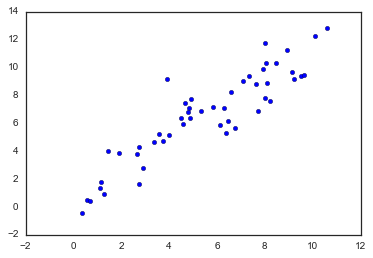

In [11]:
n = 50
x = np.linspace(1,10,n) + stats.norm.rvs(size=n)
y = x + stats.norm.rvs(loc=1, scale=1.5, size=n)
plt.scatter(x,y)

print("Pearson r: ", stats.pearsonr(x, y)[0])
print("Spearman's rho: ", stats.spearmanr(x, y)[0])
print("Kendall's tau: ", stats.kendalltau(x, y)[0])

pass

Pearson r:  0.785484667133
Spearman's rho:  0.820626654145
Kendall's tau:  0.67269984917


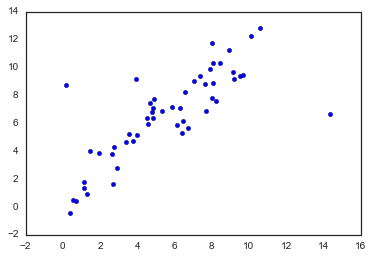

In [12]:
pollute_X = np.concatenate([x, stats.norm.rvs(loc=14, size=1), stats.norm.rvs(loc=-1, size=1)])
pollute_Y = np.concatenate([y, stats.norm.rvs(loc=6, size=1), stats.norm.rvs(loc=8, size=1)])

plt.scatter(pollute_X, pollute_Y)

print("Pearson r: ", stats.pearsonr(pollute_X, pollute_Y)[0])
print("Spearman's rho: ", stats.spearmanr(pollute_X,pollute_Y)[0])
print("Kendall's tau: ", stats.kendalltau(pollute_X,pollute_Y)[0])

# Association Between Categorical Variables

A standard approach for testing the independence/dependence of a pair of categorical variables is to use a $\chi^2$ (Chi-square) test of independence. 

The null and alternative hypotheses for the $\chi^2$ test are as follows:

* $H_0$: the two categorical variables are independent
* $H_A$: the two categorical variables are dependent

## Contingency tables

We typically depict the relationship between categorical variables using a "contingency table".

|       | B1                  | B2                  | Total                         |
|-------|---------------------|---------------------|-------------------------------|
| A1    | $c_{11}$            | $c_{12}$            | $c_{11}$+$c_{12}$               |
| A2    | $c_{21}$            | $c_{22}$            | $c_{12}$+$c_{22}$               |
| Total | $c_{11}$+$c_{21}$ | $c_{12}$+$c_{22}$ | $c_{11}$+$c_{12}$+$c_{12}$+$c_{22}$ |

The rows and columns indicate the different categories for variables A and B respectively, and the cells, $c_{ij}$ give the counts of the number of observations for the corresponding combination of A and B.  For example, the cell $c_{11}$ gives the number of observations that that belong to both the category A1 and B1, while $c_{12}$ gives the number that are both A1 and B2, etc.

In [13]:
# construct a contingency table for the sex and survival categorical variables
# from the bumpus data set
dataurl = "https://github.com/Bio204-class/bio204-datasets/raw/master/bumpus-data.txt"
bumpus = pd.read_table(dataurl)

In [14]:
observed = pd.crosstab(bumpus.survived, bumpus.sex, margins=True)
observed

sex,f,m,All
survived,,,
F,28,36,64
T,21,51,72
All,49,87,136


### Expected counts

If the two categorical variables were independent than we would expect that the count in each cell of the contigency table to equal the product of the marginal probalities times the total number of observations.

In [15]:
nobs = observed.ix['All','All']

prob_female = observed.ix['All','f']/nobs
prob_male = observed.ix['All', 'm']/nobs

prob_surv = observed.ix['T', 'All']/nobs
prob_died = observed.ix['F', 'All']/nobs

expected_counts = []
for i in (prob_died, prob_surv):
    row = []
    for j in (prob_female, prob_male):
        row.append(i * j * nobs)
    expected_counts.append(row + [np.sum(row)])
expected_counts.append(np.sum(expected_counts,axis=0).tolist())

expected = pd.DataFrame(expected_counts, index=observed.index, columns=observed.columns)

print("Table of Expected Counts")
expected

Table of Expected Counts


sex,f,m,All
survived,,,
F,23.058824,40.941176,64
T,25.941176,46.058824,72
All,49.000000,87.000000,136


In [16]:
Z2 = (observed-expected)**2/expected
Z2

sex,f,m,All
survived,,,
F,1.058824,0.596349,0
T,0.941176,0.530088,0
All,0.000000,0.000000,0


In [17]:
chi2 = np.sum(Z2.values)
chi2

3.1264367816091938

In [18]:
df = (len(bumpus.survived.unique()) - 1) * (len(bumpus.sex.unique()) - 1)
print("chi2 = {}, df = {}, pval = {}".format(chi2, df, stats.chi2.sf(chi2, df=df)))

chi2 = 3.126436781609194, df = 1, pval = 0.07703193811756107


### $X^2$-square test of independence using scipy.stats

In [19]:
# Same analysis with scipy.stats fxns
observed_nomargin = pd.crosstab(bumpus.survived, bumpus.sex, margins=False)
Chi2, Pval, Dof, Expected = stats.chi2_contingency(observed_nomargin.values, 
                                                   correction=False)

In [20]:
Chi2, Pval, Dof

(3.1264367816091938, 0.077031938117561066, 1)

In [21]:
Expected

array([[ 23.05882353,  40.94117647],
       [ 25.94117647,  46.05882353]])

In [22]:
bumpus.survived.unique()

array(['T', 'F'], dtype=object)